<h1 style="font-family:Impact,Arial;font-size:70px;">Statistical data analysis I</h1>
<h2 style="font-family:Arial;">Matias Quiroz</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:matias.quiroz@uts.edu.au" target="_blank">
<small><font color=MediumVioletRed>matias.quiroz@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

<div style="background-color:#F2FBEF;">
<h2><font color=#04B404>After completing this notebook you should:</font></h2>
<br>
<ul>
<li> Have a basic understanding of how to fit simple regression and classification models in Python using packages. </li><br>
<li> Have a basic knowledge of how to implement a method based on ordinary least squares yourself. </li><br>
</ul>
</div>


<hr style="height:5px;border:none;color:#333;background-color:#333;" />

# 1. Statistical modelling in Python

The `pandas` package is useful for data wrangling. Once the data has been prepared the fun starts. So far we have considered exploratory data analysis via visualisation and computing simple summary statistics of the data. While this is useful to gain some initial insights into the data, it does not provide a mathematical description of the data that can enable deeper insights. This notebook gives an introduction to statistical modelling in Python using existing libraries and, moreover, how Python can be used to write your own code to fit statistical models. The latter is important because:

- A package might not exist for the model you want to fit. This is usually the case when you do methodological research.

- Perhaps you want to tweak a model setting and you may not be able to control everything in an existing package. 

- There is no other way to better understand a model or a method than coding it yourself alongside with doing the maths (e.g. deriving the likelihood function of the model).

A *statistical model* is a mathematical description of the data that accounts for variation by modelling the data using a probability distribution. The statistical model serves two main purposes:

- It provides a compact representation of the data. This can be used to study, for example, relationships between variables. 

- It can be used to extrapolate beyond the data, e.g. used to predict yet unseen data.

The latter is the main focus of *machine learning*. It can be argued that machine learning is similar to computational statistics, which is a branch of statistics that has gained widespread popularity with the advances in computer technology. A popular open-source machine learning library for Python is `scikit-learn`. The library provides a wide range of algorithms for classification and regression, among other methods. These methods use a set of input variables to predict an output variable. When the output variable is numerical (either continuous or discrete) this is known as regression, and when the output variable is categorical this is known as classification.

The following code installs the `scikit-learn` package.

In [1]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


<hr style="height:5px;border:none;color:#333;background-color:#333;" />

# 2. Linear regression in `scikit-learn`

When either using packages or implementing your own algorithm, it is advisable to first use simulated data to ensure that your code works properly. With simulated data, we know the answer, i.e. the true model parameters that generated the data, and can thus check if our code manages to learn (estimate) them correctly. Due to the randomness of the data generating process, however, we will not be able to obtain the exact values. We hope for estimates that are reasonably close and get closer to the true values if we increase the sample size. This is known as consistency in statistics.

The following code simulates $1000$ observations from the linear regression model

$$y_i = \beta_0 + \beta_1 x_i + \varepsilon_i, \quad \varepsilon_i \stackrel{\mathrm{ind}}{\sim} \mathcal{N}(0, \sigma^2_{\varepsilon}),$$

with $\beta_0 = 2.1$, $\beta_1 = 0.7$, and $\sigma^2_{\varepsilon} = 0.1$.

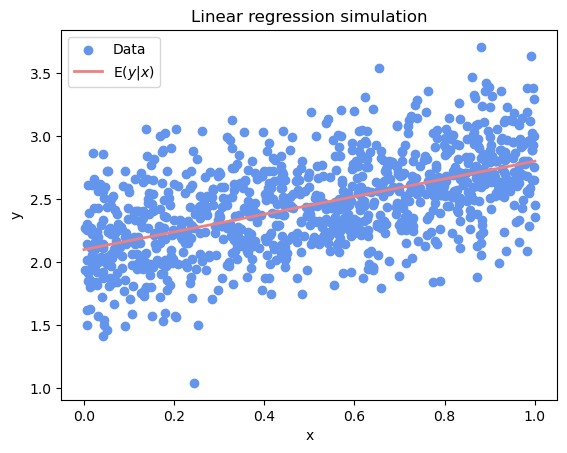

In [2]:
# Simulate 1000 observations from a linear regression model
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

# Random data from a linear regression model with noise variance 1
np.random.seed(1234)
x = sps.uniform.rvs(size = 1000)  # y will be generated given these x values
sigma2_eps = 0.1
beta0 = 2.1
beta1 = 0.7
y = beta0 + beta1*x + sps.norm.rvs(size = 1000, loc = 0, scale  = np.sqrt(sigma2_eps))

# Plot the regression points
plt.scatter(x, y, color = "cornflowerblue", label = "Data")

# Plot the regression line (E[y|X, beta]) using a grid of x-values
x_grid = np.linspace(0, 1, 100)

plt.plot(x_grid, beta0 + beta1*x_grid, color = "lightcoral", linewidth=2, label = r'$\mathrm{E}(y|x)$')

# Add labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear regression simulation")
plt.legend()

In machine learning, it is common to split a dataset of $n$ observations into a training dataset $\mathcal{T}_{\mathrm{train}}=\{x_i,y_i\}_{i=1}^{n_{\mathrm{train}}}$ and validation dataset, also known as test dataset, $\mathcal{T}_{\mathrm{test}}=\{x_i,y_i\}_{i=1}^{n_{\mathrm{test}}}$, with $n=n_{\mathrm{train}} + n_{\mathrm{test}}$. The following code splits the data into $80\%$ training data and $20\%$ test data using the `train_test_split()` function from the `model_selection` module in the `scikit-learn` package.

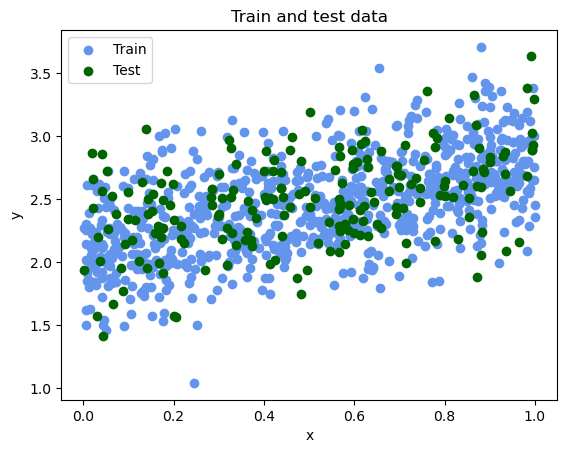

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
plt.scatter(x_train, y_train, color = "cornflowerblue", label = "Train")
plt.scatter(x_test, y_test, color = "darkgreen", label = "Test")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train and test data")
plt.legend()

The training data is used to estimate the model parameters and the validation data is used to evaluate the model's performance. In particular, when there are two (or more) candidate models for a given dataset, the validation data is useful for selecting the best model among the candidate models. For example, one can select the model that minimises some suitable error metric, such as the root mean squared error of the test data,

$$\mathrm{RMSE}_{\mathrm{test}} = \sqrt{\frac{1}{n_{\mathrm{test}}}\sum_{i \in \mathcal{T}_{\mathrm{test}}} (y_i - \widehat{y}_i)^2},$$

where $\widehat{y}_i$ is the prediction of the test observation $y_i$. In linear regression, $\widehat{y}_i = \widehat{\beta}_0 + \widehat{\beta}_1 x_i$ where $\widehat{\beta}_j$, $j=0,1$, are the estimates of the intercept and slope. Note that the estimates are obtained using the training dataset $\mathcal{T}_{\mathrm{train}}=\{x_i,y_i\}_{i=1}^{n_{\mathrm{train}}}$ only.

Another error metric is the root mean squared error of the training data,

$$\mathrm{RMSE}_{\mathrm{train}} = \sqrt{\frac{1}{n_{\mathrm{train}}}\sum_{i \in \mathcal{T}_{\mathrm{train}}} (y_i - \widehat{y}_i)^2},$$

where $\widehat{y}_i$ is the prediction of the training observation $y_i$ (it was used to estimate the model). The prediction of a training observation is sometimes referred to as a smoothed value. Note that $\mathrm{RMSE}_{\mathrm{train}}$ is not a good metric to select candidate models as it is prone to selecting models that **overfit** the training data. Such models tend to not **generalise** well, i.e. they perform poorly on the test dataset. We will not discuss this further here. The interested SSTC student is referred to the postgraduate subject *37401 Machine Learning: Mathematical Theory and Applications* that you can take if you transfer to the University of Technology Sydney. 

&nbsp;&nbsp;&nbsp;The following code estimates the model parameters and compares the estimates to the true values. Moreover, the code predicts the model for a linearly spaced input $x$ (also known as feature/covariate/variable/independent variable) and plots the true model (based on the true parameter values), the estimated model (based on the estimated parameter values), and the training data.

Estimated intercept: 2.087. True value: 2.100
Estimated slope    : 0.717. True value: 0.700


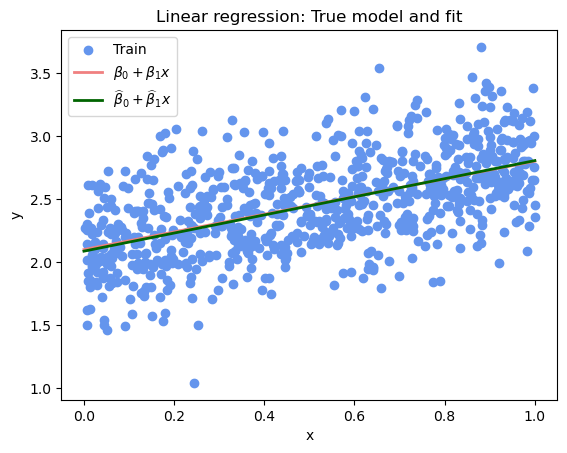

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train.reshape(-1, 1), y_train)

# Model coefficients
print('Estimated intercept: %3.3f. True value: %3.3f' % (model.intercept_, beta0))
print('Estimated slope    : %3.3f. True value: %3.3f' % (model.coef_, beta1))

x_grid = np.linspace(0, 1, 100) # predict y for these x
y_hat = model.predict(x_grid.reshape(-1, 1))

plt.scatter(x_train, y_train, color = "cornflowerblue", label = "Train")
plt.plot(x_grid, beta0 + beta1*x_grid, color = "lightcoral", linewidth=2, label = r'$\beta_0 + \beta_1x$')
plt.plot(x_grid, y_hat, color = "darkgreen", linewidth=2, label = r'$\widehat{\beta}_0 + \widehat{\beta}_1x$')

# Add labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear regression: True model and fit")
plt.legend()


Finally, the following code computes the mean squared error for the training and test data.

In [5]:
def mean_squared_error(y, y_pred):
    """
    Computes the mean squared error.
    """
    return np.mean((y - y_pred)**2)

y_pred_train = model.predict(x_train.reshape(-1, 1))
print('Root mean squared error training data: %3.3f:'% np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(x_test.reshape(-1, 1))
print('Root mean squared error test data    : %3.3f:' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
    

Root mean squared error training data: 0.311:
Root mean squared error test data    : 0.332:


Typically, $\mathrm{RMSE}_{\mathrm{train}} < \mathrm{RMSE}_{\mathrm{test}}$, because the parameters are chosen to fit the training data optimally (in some sense, see the discussion in Section 2).

<hr style="height:5px;border:none;color:#333;background-color:#333;" />

# 2. Non-linear regression in `scikit-learn`


The `LinearRegression()` function uses ordinary least squares (OLS) to estimate the parameters of the regression model. It turns out that OLS can also estimate regressions that have a **non-linear relationship between the output $y$ and input $x$**. We first present the linear regression model in matrix notation, which will be useful for explaining the extension to the non-linear case.

Recall the linear regression model

$$y_i = \beta_0 + \beta_1 x_i + \varepsilon_i, \quad \varepsilon_i \stackrel{\mathrm{ind}}{\sim} \mathcal{N}(0, \sigma^2_{\varepsilon}),$$

which we can write in matrix form as

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon}\sim \mathcal{N}(\mathbf{0}, \sigma^2_{\varepsilon}\boldsymbol{I}),$$

where $\mathbf{X} \in \mathbb{R}^{n \times 2}$ matrix with rows $\mathbf{x}^\top_i = (1, x_i)$, $\boldsymbol{\beta} = (\beta_0, \beta_1)^\top$, $\boldsymbol{\varepsilon} = (\varepsilon_1, \dots, \varepsilon_n)^\top$, and $\boldsymbol{I}_{n}$ denotes the $n\times n$ identity matrix. The OLS estimator is obtained by minimising the error sum of squares, i.e.

$$\widehat{\boldsymbol{\beta}} = \underset{\boldsymbol{\beta}}{\operatorname{argmin}} \boldsymbol{\varepsilon}^\top \boldsymbol{\varepsilon} = \underset{\boldsymbol{\beta}}{\operatorname{argmin}}\,    (\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^\top (\mathbf{y} - \mathbf{X}\boldsymbol{\beta}).$$

It can be shown that this optimisation problem has the unique minimiser (by solving $\nabla_{\boldsymbol{\beta}} \,\boldsymbol{\varepsilon}^\top \boldsymbol{\varepsilon} = \mathbf{0}$ and the convexity of the objective function)

\begin{align}
  \widehat{\boldsymbol{\beta}} & = (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{y}, \label{OLS} \tag{1}
\end{align}

and that the variance-covariance matrix is

\begin{align}
  \mathrm{Cov}(\widehat{\boldsymbol{\beta}}) & = \sigma_{\varepsilon}^2 (\mathbf{X}^\top \mathbf{X})^{-1}. \label{cov_matrix} \tag{2}
\end{align}

The square root of the diagonal of the matrix in Equation ([2](#mjx-eqn-cov_matrix)) contains the standard errors of the OLS estimates. In practice, $\sigma_{\varepsilon}^2$ is unknown and can be estimated using the residual sum of squares

$$\widehat{\sigma}_{\varepsilon}^2 = \frac{1}{n - p}(\mathbf{y} - \mathbf{X}\widehat{\boldsymbol{\beta}})^\top (\mathbf{y} - \mathbf{X}\widehat{\boldsymbol{\beta}}), $$

where $p$ is the number of estimated regression coefficients.

The fitted values are computed as 

$$\widehat{\mathbf{y}}(\mathbf{X}) = \mathbf{X}\widehat{\boldsymbol{\beta}} =  \mathbf{X}(\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{y},$$

where the notation $\widehat{\mathbf{y}}(\mathbf{X})$ highlights that the predictions are for the training data $\mathbf{X}$. For some general input matrix $\widetilde{\mathbf{X}}$ (with the first column being a vector of ones), the predictions are

\begin{align}
\widehat{\mathbf{y}}(\widetilde{\mathbf{X}}) & = \widetilde{\mathbf{X}}(\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{y}. \label{predict} \tag{3}
\end{align}


&nbsp;&nbsp;&nbsp;We now turn to the non-linear regression case. To exemplify, consider the following non-linear regression model between $y$ and $z$,

\begin{align}
  y_i & = \beta_0 + \beta_1 z_i + \beta_2 \log(z_i) + \beta_3 z_i^2 + \varepsilon_i, \quad \varepsilon_i \stackrel{\mathrm{ind}}{\sim} \mathcal{N}(0, \sigma^2_{\varepsilon}) \label{nonlinearreg} \tag{4}.
\end{align}

The following code generates data from this model with $\beta_0 = 2.1$, $\beta_1 = 0.7$, $\beta_2 = -1.5$, $\beta_3 = -1.3$, and $\sigma^2_{\varepsilon} = 0.1$. The code also splits the dataset into training and validation sets.



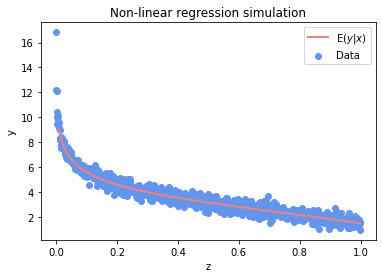

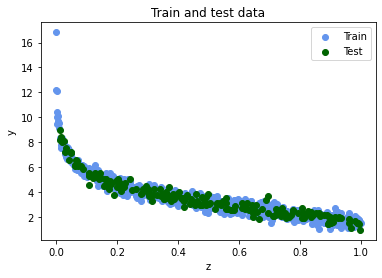

In [6]:
sigma2_eps = 0.1
beta0 = 2.1
beta1 = 0.7
beta2 = -1.5
beta3 = -1.3

z = sps.uniform.rvs(size = 1000)  # y will be generated given these z values
# Simulate response
y = beta0 + beta1*z + beta2*np.log(z) + beta3*z**2 + sps.norm.rvs(size = 1000, loc = 0, scale  = np.sqrt(sigma2_eps))

plt.scatter(z, y, color = "cornflowerblue", label = "Data")

# Plot the regression line (E[y|X, beta]) using a grid of z-values
z_grid = np.linspace(0.01, 1, 100)

plt.plot(z_grid, beta0 + beta1*z_grid + beta2*np.log(z_grid) + beta3*z_grid**2, color = "lightcoral", linewidth=2, label = r'$\mathrm{E}(y|x)$')

# Add labels and title
plt.xlabel("z")
plt.ylabel("y")
plt.title("Non-linear regression simulation")
plt.legend()

# Train test split
plt.figure()
X = np.vstack((np.ones(1000), z, np.log(z), z**2)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
plt.scatter(X_train[:, 1], y_train, color = "cornflowerblue", label = "Train")
plt.scatter(X_test[:, 1], y_test, color = "darkgreen", label = "Test")
plt.xlabel("z")
plt.ylabel("y")
plt.title("Train and test data")
plt.legend()

We can rewrite Equation ([4](#mjx-eqn-nonlinearreg)) in matrix form as

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon}\sim \mathcal{N}(\mathbf{0}, \sigma^2_{\varepsilon}\boldsymbol{I}),$$

where $\mathbf{X} \in \mathbb{R}^{n \times 4}$ matrix with rows $\mathbf{x}^\top_i = (1, z_i, \log(z_i), z^2_i)$, $\boldsymbol{\beta} = (\beta_0, \beta_1, \beta_2, \beta_3)^\top$, $\boldsymbol{\varepsilon} = (\varepsilon_1, \dots, \varepsilon_n)^\top$, and $\boldsymbol{I}_{n}$ denotes the $n\times n$ identity matrix. Although the model is non-linear in terms of the data $z$, it is linear in terms of the parameters $\boldsymbol{\beta}$. Thus, the OLS solution is still ([1](#mjx-eqn-OLS)) (with a different feature matrix $\mathbf{X}$). 

&nbsp;&nbsp;&nbsp;To summarise: The non-linear regression case only requires us to create a feature matrix $\mathbf{X}$ by applying transformations to the original variable. The code below fits the non-linear regression model using the `LinearRegression()` function and, in addition, computes $95\%$ confidence intervals for the parameter estimates.



Estimated parameters : [ 2.097  0.701 -1.506 -1.293]. True value: [2.1, 0.7, -1.5, -1.3]
Standard errors: [0.104 0.281 0.029 0.208]. 
Approximate 95% confidence intervals
[ 1.894  0.15  -1.562 -1.7  ]
[ 2.301  1.253 -1.449 -0.886]


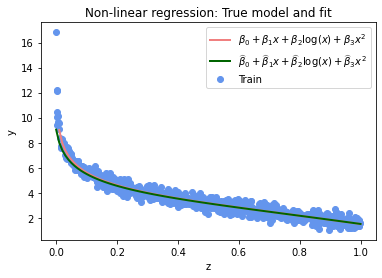

In [7]:
model = LinearRegression(fit_intercept = False) # Intercept is in X_train
n, p = X_train.shape
model.fit(X_train, y_train) # Intercept is in X_train

# Model coefficients
print('Estimated parameters : %s. True value: %s' % (np.round(model.coef_, 3), [beta0, beta1, beta2, beta3]))
sigma2_eps_hat = np.dot(y_train - model.predict(X_train), y_train - model.predict(X_train))/(n - p)
standard_errors = np.sqrt(np.diag(sigma2_eps_hat*np.linalg.inv(np.dot(X_train.T, X_train))))
print('Standard errors: %s. ' % np.round(standard_errors, 3))
print('Approximate 95% confidence intervals')
lower_CI = model.coef_ - 1.96*standard_errors
upper_CI = model.coef_ + 1.96*standard_errors
print(np.round(lower_CI, 3))
print(np.round(upper_CI, 3))

z_grid = np.linspace(0.01, 1, 100) # predict y for these z
X_grid = np.vstack((np.ones(100), z_grid, np.log(z_grid), z_grid**2)).T

y_hat = model.predict(X_grid)

plt.scatter(X_train[:, 1], y_train, color = "cornflowerblue", label = "Train")
plt.plot(X_grid[:, 1], np.dot(X_grid, np.array([beta0, beta1, beta2, beta3])), color = "lightcoral", linewidth=2, label = r'$\beta_0 + \beta_1x + \beta_2\log(x) + \beta_3x^2$')
plt.plot(x_grid, y_hat, color = "darkgreen", linewidth=2, label = r'$\widehat{\beta}_0 + \widehat{\beta}_1x + \widehat{\beta}_2\log(x) + \widehat{\beta}_3x^2$')

# Add labels and title
plt.xlabel("z")
plt.ylabel("y")
plt.title("Non-linear regression: True model and fit")
plt.legend()

Finally, we note that, in practice, the non-linear transformations (such as $\log(z), z^2$ above) are not known and thus prevent the simple construction of the feature matrix above. A popular approach is to use a so-called spline basis to model the non-linearities. Below is an example using the so-called B-spline basis. The details are omitted and the interested student is referred to *37401 Machine Learning: Mathematical Theory and Applications*.

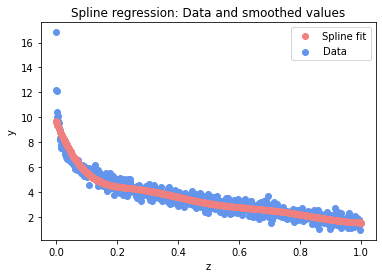

In [8]:
from sklearn.preprocessing import SplineTransformer

# Create a new model to not overwrite the results in the previous one
model_splines = LinearRegression()

# Create a SplineTransformer with cubic splines and 5 knots.
spline = SplineTransformer(degree = 3, n_knots = 5, include_bias = False)

# Fit the spline and create the feature matrix (without the intercept)
X_spline = spline.fit_transform(z.reshape(-1, 1))

# Add the intercept. Fit using all data (for illustration purposes)
X_spline = np.hstack((np.ones((1000, 1)), X_spline))

model_splines.fit(X_spline, y)

# Smoothed values and data
y_fit = model_splines.predict(X_spline)

plt.scatter(X[:, 1], y, color = "cornflowerblue", label = "Data")
plt.plot(X[:, 1], y_fit, marker = "o", linestyle = 'None', color = "lightcoral", label = 'Spline fit')

# Add labels and title
plt.xlabel("z")
plt.ylabel("y")
plt.title("Spline regression: Data and smoothed values")
plt.legend()


<hr style="height:5px;border:none;color:#333;background-color:#333;" />

# 3. Regression without `scikit-learn`

In Sections 2 and 3, the `LinearRegression()` function was used to:

1. Estimate the coefficients of the regression model.
2. Predict the response variable $y$ for a given input $\widetilde{\mathbf{x}}$.

Mathematically, these two tasks are solved by implementing Equations ([1](#mjx-eqn-OLS)) and ([3](#mjx-eqn-prediction)). By implementing these equations ourselves we can estimate a regression model and produce predictions without using the `LinearRegression()` function as follows.

In [9]:
beta_hat = np.linalg.solve(np.dot(X_train.T, X_train), np.dot(X_train.T, y_train))
print('Estimating ourselves     : %s' % beta_hat)
print('Using LinearRegression() : %s' % model.coef_)

print('--------------------------------------------------')
print('Predicting first 10 test observations ourselves: ')
print(np.dot(X_test[:10, ], beta_hat))
print('Predicting first 10 test observations using LinearRegression:')
print(model.predict(X_test[:10, ]))

Estimating ourselves     : [ 2.09736413  0.70123454 -1.50564856 -1.29324422]
Using LinearRegression() : [ 2.09736413  0.70123454 -1.50564856 -1.29324422]
--------------------------------------------------
Predicting first 10 test observations ourselves: 
[2.90545381 3.76216469 2.79349177 2.96848036 2.63870156 4.54446518
 3.46913987 7.29622557 1.95472303 4.08243809]
Predicting first 10 test observations using LinearRegression:
[2.90545381 3.76216469 2.79349177 2.96848036 2.63870156 4.54446518
 3.46913987 7.29622557 1.95472303 4.08243809]


<hr style="height:5px;border:none;color:#333;background-color:#333;" />

# 4. Logistic regression with `scikit-learn`

We now consider classification models to model the relationship between the input $\mathbf{x}$ and the categorical output $y$. For simplicity, we consider a categorical output with only two outcomes, coded as $1$ ("success") and $0$ ("failure"), i.e. $y \in \{0,1\}$.

&nbsp;&nbsp;&nbsp; Unlike the regression problem above, it does not make sense to write

$$y_i = \beta_0 + \beta_1 x_i + \varepsilon_i,$$

for some error term $\varepsilon_i$ because we know that the left hand side is 0 or 1, and we cannot find an error term that together with the $\beta_0 + \beta_1 x_i$ adds to this. Instead, we model the probability that $y_i=0$ or $y_i=1$. It suffices to model only one of the cases, typically $\Pr(y_i=1)$, since the other follows from the complement $\Pr(y_i = 0) = 1 - \Pr(y_i = 1)$. Since the probability is restricted to the interval $[0, 1]$, the linear probability model 

$$\Pr(y_i = 1) = \beta_0 + \beta_1 x_i,$$

is not so commonly used. The so-called logistic regression model is much more popular and can be formulated as 

\begin{align}
\Pr(y_i = 1) & = \frac{1}{1 + \exp(-z_i)}, \, z_i = \beta_0 + \beta_1 x_i,\label{logistic} \tag{5}
\end{align}

which ensures that $\Pr(y_i = 1) \in [0, 1]$. The parameters can be interpreted via the so-called log-odds

$$\log\left( \frac{\Pr(y_i = 1)}{\Pr(y = 0)}\right) =  \beta_0 + \beta_1 x_i.$$

Similar to the regression case above, the log-odds can be modelled non-linearly by feature expansions of $x$ (e.g. spline basis), however, we will not pursue this further here.

&nbsp;&nbsp;&nbsp;The following code simulates 1000 observations from the model in Equation ([5](#mjx-eqn-logistic)) with $\beta_0 = -4.5$ and $\beta_1 = 6.5$. The code plots 100 randomly selected observations (to avoid a cluttered plot) together with the probability of success as a function of $x$.



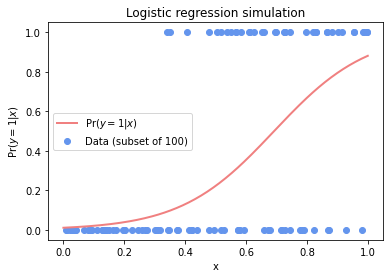

In [10]:
# Simulate 100 observations from a logistic regression model
np.random.seed(1234)
x = sps.uniform.rvs(size = 1000)  # y will be generated given these x values
beta0 = -4.5
beta1 = 6.5
z = beta0 + beta1*x 
y = sps.bernoulli.rvs(size = 1000, p = 1/(1 + np.exp(-z)))

# Plot a subset of the regression points (y is zero or one)
subset = np.random.choice(np.arange(1000), 100, replace = False)
plt.scatter(x[subset], y[subset], color = "cornflowerblue", label = "Data (subset of 100)")

# Plot the regression line (Pr(y = 1|x)) using a grid of x-values
x_grid = np.linspace(0, 1, 200)
z_grid =  beta0 + beta1*x_grid 

plt.plot(x_grid, 1/(1 + np.exp(-z_grid)), color = "lightcoral", linewidth=2, label = r'$\Pr(y = 1|x)$')

# Add labels and title
plt.xlabel("x")
plt.ylabel(r'$\Pr(y = 1|x)$')
plt.title("Logistic regression simulation")
plt.legend()

The following code splits the dataset into training and validation sets and estimates a logistic regression model using the `scikit-learn` package.

Estimated intercept: -4.967. True value: -4.500
Estimated slope    : 7.195. True value: 6.500


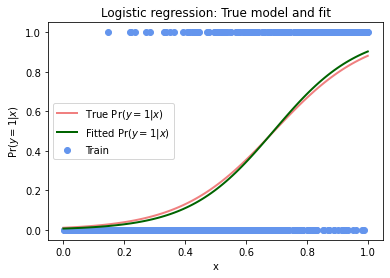

In [11]:
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model_logistic = LogisticRegression(penalty = None)
model_logistic.fit(x_train.reshape(-1, 1), y_train)

print('Estimated intercept: %3.3f. True value: %3.3f' % (model_logistic.intercept_, beta0))
print('Estimated slope    : %3.3f. True value: %3.3f' % (model_logistic.coef_, beta1))

x_grid = np.linspace(0, 1, 100) # predict y for these x
z_grid =  beta0 + beta1*x_grid
y_prob_hat = model_logistic.predict_proba(x_grid.reshape(-1, 1))[:, 1]


plt.scatter(x_train, y_train, color = "cornflowerblue", label = "Train")
plt.plot(x_grid, 1/(1 + np.exp(-z_grid)), color = "lightcoral", linewidth=2, label = r'True $\Pr(y = 1|x)$')
plt.plot(x_grid, y_prob_hat, color = "darkgreen", linewidth=2, label = r'Fitted $\Pr(y = 1|x)$')

# Add labels and title
plt.xlabel("x")
plt.ylabel(r'$\Pr(y = 1 |x)$')
plt.title("Logistic regression: True model and fit")
plt.legend()


In the code above, note how we use the method `predict_proba()` in place of `predict()`. The former method returns the estimated probability of success while the latter returns the class, i.e. the estimated outcome (0 or 1). The classifier predicts the class according to

$$\widehat{y}_i(x_i) = \underset{m \in \{0, 1\}}{\operatorname{argmax}} \Pr(y = m|x_i),$$

where $\Pr(y = m|x_i)$ are obtained via `predict_proba()`. 

&nbsp;&nbsp;&nbsp;The root mean squared error is not suitable in this case because the response variable is not continuous. The misclassification rate is more commonly used,

$$\mathrm{MCR}_{\mathrm{test}} = \frac{1}{n_{\mathrm{test}}}\sum_{i \in \mathcal{T}_{\mathrm{test}}} \mathbb{1}(y_i \neq \widehat{y}_i),$$

where $\mathbb{1}(A)$ is the indicator function which is one when $A$ is true and zero otherwise. The corresponding quantity for the training data is

$$\mathrm{MCR}_{\mathrm{train}} = \frac{1}{n_{\mathrm{train}}}\sum_{i \in \mathcal{T}_{\mathrm{train}}} \mathbb{1}(y_i \neq \widehat{y}_i).$$

&nbsp;&nbsp;&nbsp;The following code computes the misclassification rate for the training and test data.

In [12]:
def misclass_rate(y, y_pred):
    """
    Computes the mean squared error.
    """
    return np.mean((y != y_pred))

y_pred_train = model_logistic.predict(x_train.reshape(-1, 1))
print('Misclassification rate training data: %3.3f:'% misclass_rate(y_train, y_pred_train))

y_pred_test = model_logistic.predict(x_test.reshape(-1, 1))
print('Misclassification rate test data    : %3.3f:' % misclass_rate(y_test, y_pred_test))

Misclassification rate training data: 0.177:
Misclassification rate test data    : 0.195:


<div>
<br>
<br>
<br>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />
<h1> Practice, Practice, Practice </h1>

<ol>
<li>Go through the notebook again and check that you have understood everything covered.</li><br>


<li> Do the tutorial problems that you can find on Canvas.</li><br>
</ol>
</div>


> Material by Matias Quiroz